In [ ]:
!pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [5]:
import tensorflow as tf
import api.capital_features_api as cf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=35602)
validation_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=35603)

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['featuresT'], train_data['upSignals']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data['featuresT'], validation_data['upSignals']))
BATCH_SIZE = 64  # 你可以根据需要调整这个值
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [8]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['upSignals']),
    y=train_data['upSignals']
)
class_weights = dict(zip(np.unique(train_data['upSignals']), weights))

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(6, 11)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 256)            274432    
                                                                 
 dropout (Dropout)           (None, 6, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 dropout_1 (Dropout)         (None, 6, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 512)               3

In [16]:
his_up = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, verbose=1, callbacks=[], class_weight=class_weights)

Epoch 1/20
320/320 [==============================] - 5s 17ms/step - loss: 0.6930 - acc: 0.5173 - precision: 0.4175 - recall: 0.4974 - val_loss: 0.6945 - val_acc: 0.4642 - val_precision: 0.4573 - val_recall: 0.9082
Epoch 2/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6929 - acc: 0.5203 - precision: 0.4187 - recall: 0.4863 - val_loss: 0.6943 - val_acc: 0.4785 - val_precision: 0.4612 - val_recall: 0.8233
Epoch 3/20
320/320 [==============================] - 5s 16ms/step - loss: 0.6930 - acc: 0.4914 - precision: 0.4125 - recall: 0.6145 - val_loss: 0.6949 - val_acc: 0.4587 - val_precision: 0.4563 - val_recall: 0.9489
Epoch 4/20
320/320 [==============================] - 5s 17ms/step - loss: 0.6926 - acc: 0.5185 - precision: 0.4219 - recall: 0.5227 - val_loss: 0.6931 - val_acc: 0.5140 - val_precision: 0.4755 - val_recall: 0.5914
Epoch 5/20
320/320 [==============================] - 6s 18ms/step - loss: 0.6923 - acc: 0.5126 - precision: 0.4231 - recall: 0.5727 - val_l

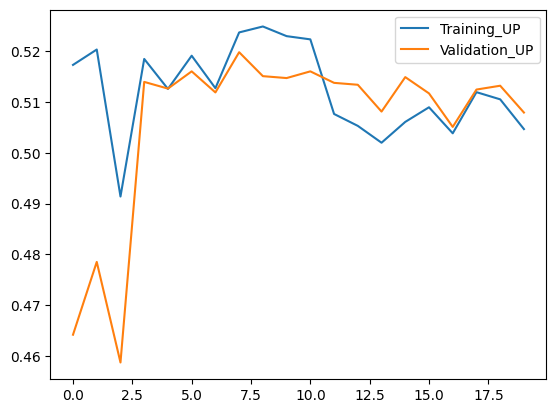

In [17]:
plt.plot(his_up.history['acc'], label='Training_UP')
plt.plot(his_up.history['val_acc'], label='Validation_UP')
plt.legend()
plt.show()

In [ ]:
len(train_data['upSignals'])

In [ ]:
train_data['upSignals'].count(1)

In [ ]:
train_data['upSignals'].count(0)